# Распознование дорожных знаков

In [106]:
import pandas as pd
import sys
import math
import numpy as np

from threading import Thread, Lock
from PIL import Image

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

Зададим констатны

In [107]:
directions = 8
field_size = 8, 8
image_size = 64, 64
indentation = 8
eps = 1e-5
field_count = (image_size[0] - 2 * indentation) // field_size[0]

## Обработка тренировочных данных

Считывание csv файла

In [108]:
Train = pd.read_csv("../train/gt.csv")

Извлечение признаков из картинки

In [109]:
def extract_hog(img):
    img = img.resize(image_size, Image.ANTIALIAS)
    pix = img.convert('RGB').load()
    
    hog = [[0 for j in range(directions)] for i in range(field_count ** 2)]
    color = [0 for i in range(3)]
    
    for i in range(indentation, image_size[0] - indentation):
        for j in range(indentation, image_size[1] - indentation):
            for l in range(3):
                color[l] += pix[j, i][l]
    
    s = sum(color)
    for i in range(3):
        color[i] /= s
        
    pix = img.convert('L').load()
    
    for i in range(indentation, image_size[0] - indentation):
        for j in range(indentation, image_size[1] - indentation):
            gradient_x = pix[j + 1, i - 1] + 2 * pix[j + 1, i] + pix[j + 1, i + 1] -\
                         pix[j - 1, i - 1] - 2 * pix[j - 1, i] - pix[j - 1, i + 1]
            gradient_y = pix[j - 1, i + 1] + 2 * pix[j, i + 1] + pix[j + 1, i + 1] -\
                         pix[j - 1, i - 1] - 2 * pix[j, i - 1] - pix[j + 1, i - 1]
            gradient_norm = (gradient_x ** 2 + gradient_y ** 2) ** (1 / 2)
            gradient_angle = math.atan2(gradient_y, gradient_x)
            hog[((i - indentation) // field_size[0]) * field_count + (j - indentation) // field_size[0]]\
                [int(abs(gradient_angle + math.pi - eps) * (directions // 2) / math.pi)] += gradient_norm
    
    for field in hog:
        norm = 0
        for i in field:
            norm += i ** 2
        norm = norm ** (1 / 2)
        for i in range(len(field)):
            field[i] /= norm + eps
    
    return hog, color

Извлечём признаки для всех картинок из тренировочной выборки

In [110]:
def thread_func(l, k):
    for i in range(Train.shape[0] * l // k, Train.shape[0] * (l + 1) // k):
        mutex.acquire()
        img = Image.open("../train/" + Train['filename'][i])
        mutex.release()
        hog, color = extract_hog(img)
        mutex.acquire()
        for j in range(3):
            Train.set_value(i, str(j), color[j])
        for j in range(len(hog)):
            for r in range(len(hog[j])):
                Train.set_value(i, str(j * 8 + r + 3), hog[j][r])
        mutex.release()

In [111]:
thread_count = 8
threads = []
mutex = Lock()
for i in range(thread_count):
    t = Thread(target=thread_func, args=(i, thread_count))
    threads.append(t)
for i in range(thread_count):
    threads[i].start()
for i in range(thread_count):
    threads[i].join()

Запишем данные файл для быстрого доступа к этим данным при следующих запусках

In [112]:
Train.to_csv("train.csv")

## Обработка тестовых данных

Создаём пусто DataFrame

In [113]:
# Test = pd.DataFrame(index=[i for i in range(12342)])

Функция для обработки имени файла

In [114]:
# def sstr(i):
#     res = str(i)
#     while len(res) < 5:
#         res = '0' + res
#     return res

Добавим дополнительные столбцы для признаков:

In [115]:
# for i in range((field_count ** 2) * directions):
#     Test[str(i)] = 0.0

Извлечём признаки для всех картинок из тренировочной выборки

In [116]:
# def thread_func_test(l, k):
#     for i in range(Test.shape[0] * l // k, Test.shape[0] * (l + 1) // k):
#         mutex.acquire()
#         img = Image.open("../test/" + sstr(i) + ".png")
#         mutex.release()
#         hog = extract_hog(img)
#         mutex.acquire()
#         for j in range(len(hog)):
#             for r in range(len(hog[j])):
#                 Test.set_value(i, str(j * 8 + r), hog[j][r])
#         mutex.release()

In [117]:
# thread_count = 8
# threads = []
# mutex = Lock()
# for i in range(thread_count):
#     t = Thread(target=thread_func_test, args=(i, thread_count))
#     threads.append(t)
# for i in range(thread_count):
#     threads[i].start()
# for i in range(thread_count):
#     threads[i].join()

Запишем данные файл для быстрого доступа к этим данным при следующих запусках

In [118]:
# Test.to_csv("test.csv")

## Окончательная обработка данных

Считывание данных

In [119]:
# Train = pd.read_csv("train.csv")
# Test = pd.read_csv("test.csv")

Удаление лишних столбцов

In [120]:
del Train["filename"]
# del Train["Unnamed: 0"]
# del Test["Unnamed: 0"]

Запишем ответы

In [121]:
Train_y = pd.DataFrame(data=Train["class_id"], columns=["class_id"])
del Train["class_id"]

## Нахождение вектора ответов методом SVM

Простая кросс-валидация

In [122]:
# learn = SVC()
# cross_val_score(learn, Train.values, y=Train_y.values[:, 0], n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42)).mean()

Обучение

In [123]:
learns = SVC()
learns.fit(Train.values, Train_y.values[:, 0])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [124]:
learnk = KNeighborsClassifier(n_neighbors=1)
learnk.fit(Train.values, Train_y.values[:, 0])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [125]:
def cut_picture(img):
    width = img.size[0]
    height = img.size[1]
    Test = pd.DataFrame(index=[i for i in range(((width - 64) // 24 + 1) * ((height - 64) // 24 + 1))])
    Test_y = Test.copy()
    k = 0
    for i in range(0, height - 63, 24):
        for j in range(0, width - 63, 24):
            img2 = img.crop((j, i, j + 64, i + 64))
            Test_y.set_value(k, 'x', j)
            Test_y.set_value(k, 'y', i)
            hog, color = extract_hog(img2)
            l = 0
            for j in color:
                Test.set_value(k, str(l), j)
                l += 1
            for field in hog:
                for h in field:
                    Test.set_value(k, str(l), h)
                    l += 1
            k += 1
    return Test, Test_y

In [126]:
Res = pd.DataFrame(index=[i for i in range(10)])
TestSVM = pd.DataFrame(index=[i for i in range(10)])
for i in range(10):
    Test, Test_y = cut_picture(Image.open("../TrainIJCNN2013/" + sstr(i) + ".ppm"))
    dist, ind = learnk.kneighbors(Test.values)
    j = np.argmin(dist)
    for s in Test.columns:
        TestSVM.set_value(i, s, Test[s][j])
    Res.set_value(i, 'x1', Test_y['x'][j])
    Res.set_value(i, 'y1', Test_y['y'][j])
    Res.set_value(i, 'x2', Test_y['x'][j] + 64)
    Res.set_value(i, 'y2', Test_y['y'][j] + 64)

Запишем результат в файл

In [128]:
score = learns.predict(TestSVM.values)
for i in range(10):
    Res.set_value(i, 'ans', score[i])
Res.to_csv("result.csv", index=False)

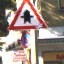

In [67]:
img = Image.open("../TrainIJCNN2013/" + sstr(0) + ".ppm")
img.crop((768,416,832,480))